## Master thesis: Car Sales Forecasting in Finland using Machine Learning

### Install Required Libraries

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install pycaret --user

### Loading data

In [36]:
import pandas as pd
import time

# Input filename, path to source files and output filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'
filename = path + 'Retails_ALL_CY11_CY22.xlsx'
external_filename = path + 'External_indicators.xlsx'

start_time = time.time()

# Load files into pandas dataframes
df = pd.concat(pd.read_excel(filename, sheet_name=None), ignore_index=True)
df_external = pd.concat(pd.read_excel(external_filename, sheet_name=None), ignore_index=True)

end_time = time.time()
time_elapsed = end_time - start_time 
print('Completed in %f seconds.' % time_elapsed)

Completed in 151.998406 seconds.


### Preprocessing data

In [37]:
# Get only Finland orders
df = df[df.RetailCountry == 'FIN']

# Remove duplicates by "orderNumber"
df.drop_duplicates(subset=['orderNumber'], keep='last', inplace=True)

# Remove unnecessary columns
df.drop(['vehOrderClassCode', 'RetailNSC', 'NSCModelGroupCode',
       'ReportingModelGroup', 'FleetCode', 'DealerCodeRetail',
       'orderCreatedDate', 'RetailCountry', 'ModelGroup',
       'EndItem', 'EIColourCode', 'DealerDeliveryAddrNoRetail',
       'FinancialOwnerCategoryCurrent', 'FinancialOwnerCategoryNext',
       'RetailCount', 'Month'], axis=1, inplace=True)

In [38]:
# Convert RetailDate to date
df['RetailDate'] = pd.to_datetime(df['RetailDate'], dayfirst=True).dt.date
# Get year of the ReailDate
df['year'] = pd.DatetimeIndex(df['RetailDate']).year
# Get month of the RetailDate
df['month'] = pd.DatetimeIndex(df['RetailDate']).month

In [39]:
# Preview dataframe
df

orderNumber  RetailDate  year  month
2       NNE0161192  2011-01-03  2011      1
3       NNE0146363  2011-01-03  2011      1
4       NNE0147851  2011-01-03  2011      1
5       NNE0144683  2011-01-03  2011      1
6       NNE0151309  2011-01-03  2011      1
...            ...         ...   ...    ...
465317  NNE0646993  2022-08-15  2022      8
465346  NNE0646781  2022-08-08  2022      8
465350  NNE0646864  2022-08-12  2022      8
465351  NNE0646872  2022-08-11  2022      8
465352  NNE0646875  2022-08-10  2022      8

[76849 rows x 4 columns]

In [40]:
# Generating index by date, grouping by and counting
df = df.groupby(['year', 'month']).size().reset_index(name='Orders')
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df.drop(['year', 'month'], axis=1, inplace=True)
df = df.set_index("Date")

In [41]:
# Preview dataframe
df

Orders
Date              
2011-01-01     900
2011-02-01     672
2011-03-01     916
2011-04-01     786
2011-05-01     763
...            ...
2022-04-01     320
2022-05-01     224
2022-06-01     233
2022-07-01     117
2022-08-01     255

[140 rows x 1 columns]

In [42]:
# Set Date as index in the external dataset
df_external.set_index('Date', inplace=True)

# Remove unnecessary columns
df_external.drop(['Light_fuel_oil', 'Diesel', 'Petrol_95',
       'Petrol_98', 'Passenger_cars', 'Vans'], axis=1, inplace=True)

In [43]:
# Merge both dataframes
data = pd.concat([df,df_external], axis=1)

In [44]:
# Preview dataframe
data

Orders   CCI     CPI   CoL  Avg_fuel_price    TIV  \
Date                                                            
2011-01-01     900   0.3  101.78  1783          1.3575  14993   
2011-02-01     672   0.4  102.40  1794          1.3500  10270   
2011-03-01     916  -0.2  102.96  1804          1.4100  13927   
2011-04-01     786  -0.6  103.16  1807          1.4200  12491   
2011-05-01     763  -1.5  103.21  1808          1.4150  14219   
...            ...   ...     ...   ...             ...    ...   
2022-04-01     320 -11.7  121.09  2121          2.0600   7220   
2022-05-01     224 -11.6  122.67  2149          2.1750   8798   
2022-06-01     233 -14.3  123.56  2165          2.4075   8305   
2022-07-01     117 -15.9  123.96  2172          2.2000   6101   
2022-08-01     255 -14.9  124.05  2173          2.0200   8163   

            Active_Population_1K_persons  Employed_1K_persons  \
Date                                                            
2011-01-01                          2584                 2363   
2011-02-01                          2619                 2395   
2011-03-01                          2596                 2340   
2011-04-01                          2650                 2428   
2011-05-01                          2754                 2483   
...                                  ...                  ...   
2022-04-01                          2782                 2589   
2022-05-01                          2867                 2641   
2022-06-01                          2929                 2729   
2022-07-01                          2878                 2688   
2022-08-01                          2805                 2618   

            Unemployed_1K_persons  Unemployment_rate_%  
Date                                                    
2011-01-01                    221                  8.6  
2011-02-01                    224                  8.5  
2011-03-01                    256                  9.9  
2011-04-01                    222                  8.4  
2011-05-01                    270                  9.8  
...                           ...                  ...  
2022-04-01                    193                  6.9  
2022-05-01                    227                  7.9  
2022-06-01                    200                  6.8  
2022-07-01                    190                  6.6  
2022-08-01                    187                  6.7  

[140 rows x 10 columns]

In [45]:
# Save data to Excel so we don't need to run previous steps every time
data.to_excel("output.xlsx")  

### ** Execution can start from here **

In [10]:
import pandas as pd

# Load file into a pandas dataframe
file = 'D:/Git_Projects/5. Master_thesis/output.xlsx'
data = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)
data = data.set_index("Date")

In [11]:
# Data statistics
data.describe()

Orders         CCI         CPI          CoL  Avg_fuel_price  \
count   140.000000  140.000000  140.000000   140.000000      140.000000   
mean    548.921429   -3.393571  110.314929  1932.607143        1.416875   
std     206.945969    4.710607    4.162411    72.955559        0.204342   
min     117.000000  -15.900000  101.780000  1783.000000        1.115000   
25%     400.750000   -6.025000  108.290000  1897.000000        1.296250   
50%     539.500000   -3.700000  109.595000  1920.000000        1.397500   
75%     664.500000    0.100000  112.420000  1969.250000        1.473125   
max    1266.000000    6.800000  124.050000  2173.000000        2.407500   

                TIV  Active_Population_1K_persons  Employed_1K_persons  \
count    140.000000                    140.000000           140.000000   
mean   10213.071429                   2687.178571          2470.378571   
std     2358.765674                     75.210139            82.122865   
min     4286.000000                   2562.000000          2330.000000   
25%     8875.750000                   2626.750000          2408.750000   
50%     9962.500000                   2674.500000          2463.500000   
75%    11221.750000                   2732.500000          2529.250000   
max    25629.000000                   2929.000000          2729.000000   

       Unemployed_1K_persons  Unemployment_rate_%  
count             140.000000           140.000000  
mean              216.828571             8.075714  
std                35.169465             1.313509  
min               143.000000             5.400000  
25%               191.000000             7.000000  
50%               214.000000             8.000000  
75%               238.250000             9.000000  
max               320.000000            11.700000

In [12]:
data.isna().sum()

Orders                          0
CCI                             0
CPI                             0
CoL                             0
Avg_fuel_price                  0
TIV                             0
Active_Population_1K_persons    0
Employed_1K_persons             0
Unemployed_1K_persons           0
Unemployment_rate_%             0
dtype: int64

### Plotting data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

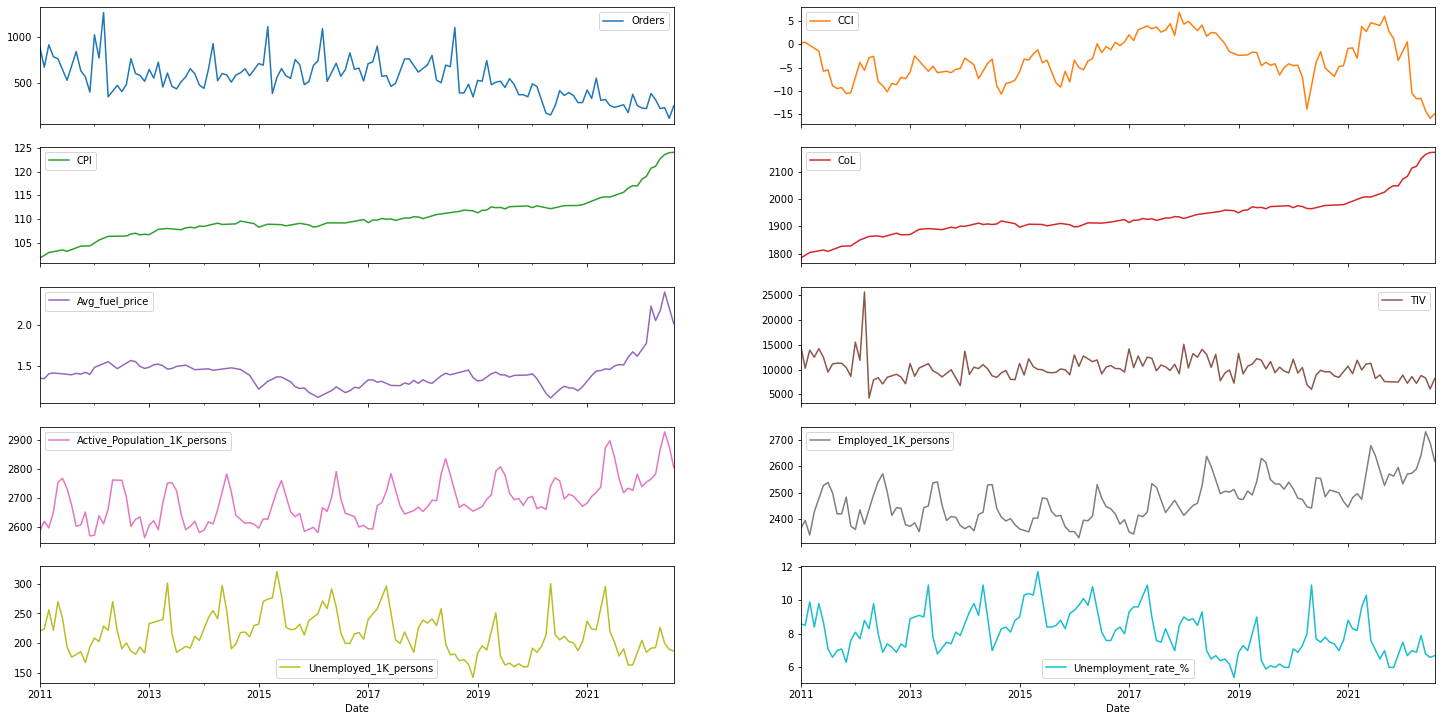

In [13]:
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.rcParams["figure.figsize"] = [25, 15]
data.plot(legend=True, subplots=True, layout=(6,2))

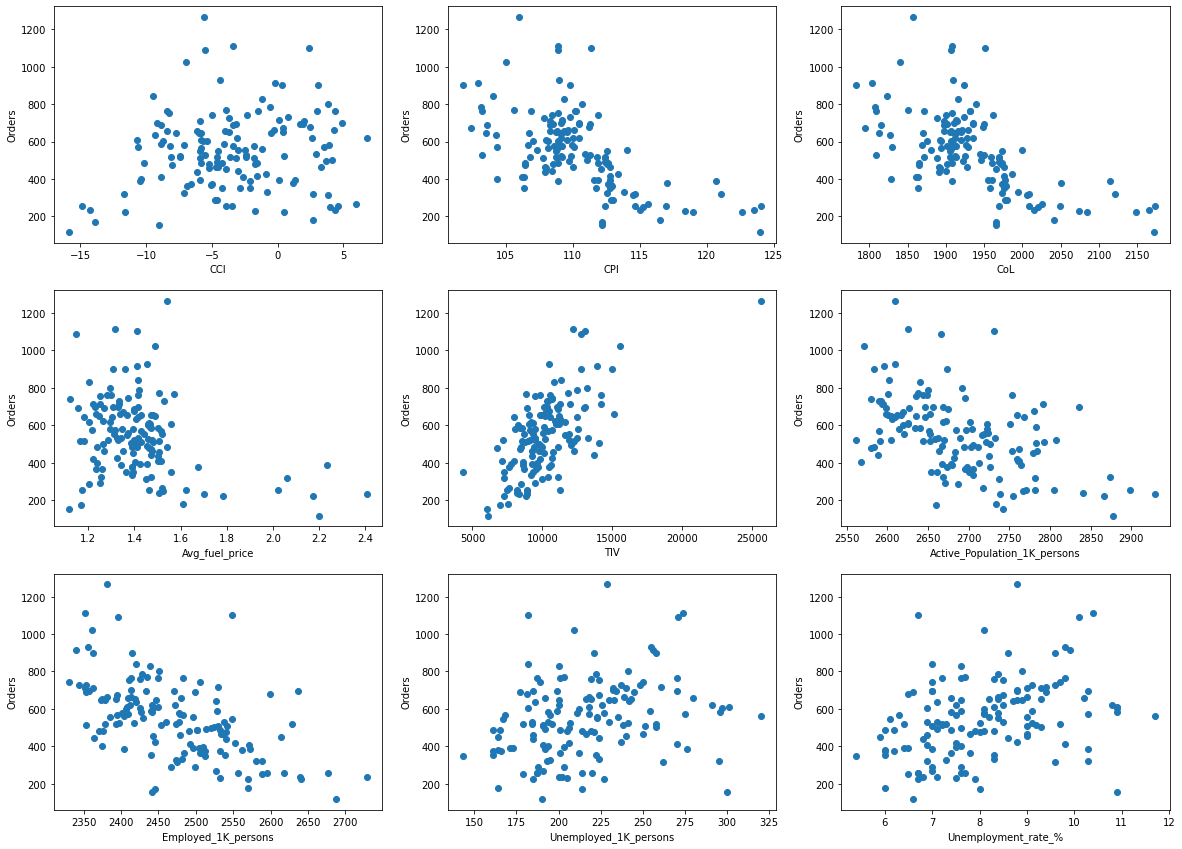

In [14]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):

    dep_var = 'Orders'                          # Dependant variable
    ind_var = df.loc[:, df.columns != 'Orders'] # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(20,20))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(data,3)

<AxesSubplot:>

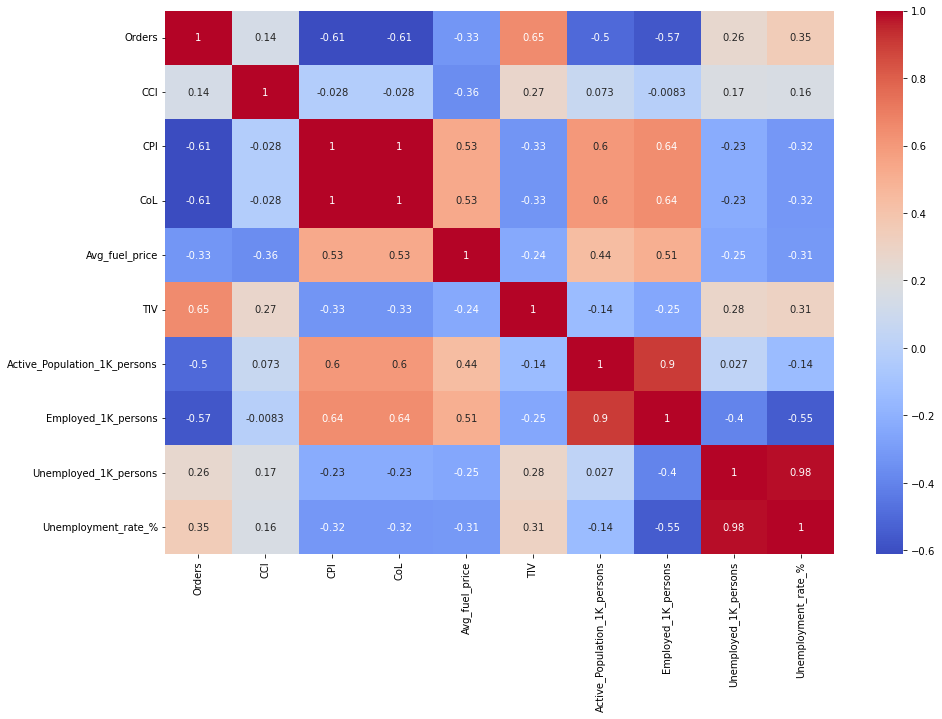

In [15]:
# Import seaborn
import seaborn as sns

# Plot the correlations as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2g')

### Pandas Profiling

https://github.com/ydataai/pandas-profiling

In [14]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="Pandas Profiling Report")

In [15]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


In [8]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((112, 9), (28, 9))

### Pycaret Analysis

https://pycaret.gitbook.io/docs/

In [18]:
from pycaret.regression import *

dataset = data
data_pycaret = dataset.sample(frac=0.8, random_state=42)
data_unseen = dataset.drop(data_pycaret.index)

data_pycaret.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data_pycaret.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

# Initial setup
model_setup=setup(data=data_pycaret,target='Orders')

# Model training and selection
best = compare_models()

# Analyze best model
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [19]:
et = create_model('et') # Extra Trees Regressor

In [20]:
br = create_model('br') # Bayesian Ridge

In [21]:
gbr = create_model('gbr') # Gradient Boosting Regressor

In [22]:
rf = create_model('rf') # Random Forest Regressor

In [23]:
lightgbm = create_model('lightgbm') # Light Gradient Boosting Machine

In [24]:
xgb = create_model('xgboost') 

In [25]:
tuned_xgb = tune_model(xgb) # Extreme Gradient Boosting

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

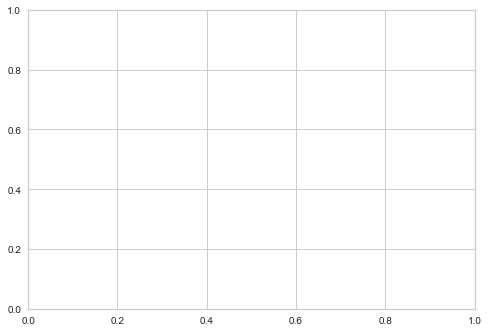

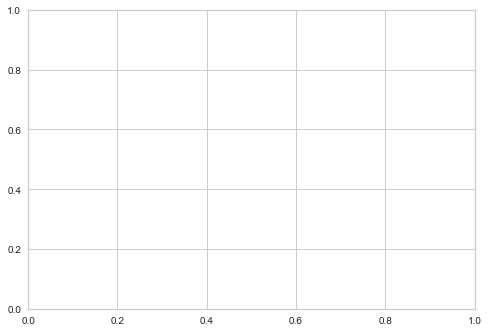

In [26]:
evaluate_model(tuned_xgb)

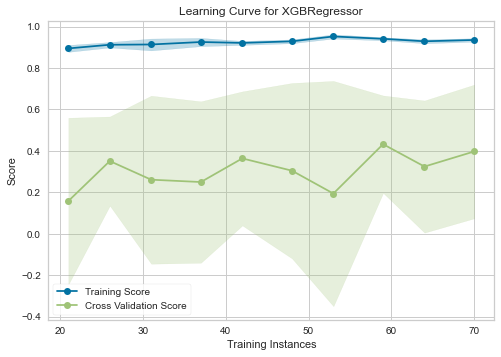

In [27]:
#+-----------------------------+-------------+
#|            Name             |    Plot     |
#+-----------------------------+-------------+
#| Residuals Plot              | ‘residuals’ |
#| Prediction Error Plot       | ‘error’     |
#| Cooks Distance Plot         | ‘cooks’     |
#| Recursive Feature Selection | ‘rfe’       |
#| Learning Curve              | ‘learning’  |
#| Validation Curve            | ‘vc’        |
#| Manifold Learning           | ‘manifold’  |
#| Feature Importance          | ‘feature’   |
#| Model Hyperparameter        | ‘parameter’ |
#+-----------------------------+-------------+

plot_model(tuned_xgb, plot ='learning')

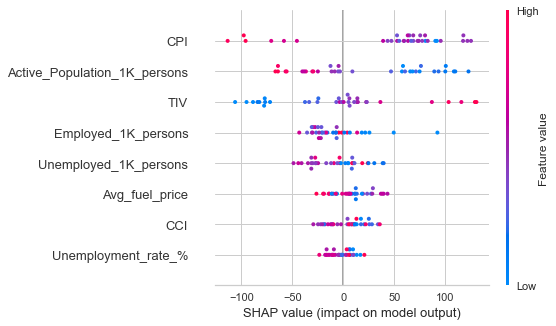

In [28]:
interpret_model(tuned_xgb)

In [29]:
predict_model(tuned_xgb)

CCI         CPI  Avg_fuel_price      TIV  Active_Population_1K_persons  \
0   -0.6  103.160004          1.4200  12491.0                        2650.0   
1    3.8  110.669998          1.2925  13221.0                        2692.0   
2   -7.1  106.669998          1.5000   8519.0                        2634.0   
3   -8.3  108.930000          1.2525   9472.0                        2635.0   
4  -14.3  123.559998          2.4075   8305.0                        2929.0   
5    0.1  109.220001          1.2500  11948.0                        2791.0   
6   -8.2  109.180000          1.3925   8037.0                        2614.0   
7   -2.3  111.910004          1.3725  10659.0                        2695.0   
8    3.0  110.230003          1.2975  10542.0                        2644.0   
9   -1.8  112.379997          1.4300  12218.0                        2793.0   
10   3.7  109.720001          1.2625   9750.0                        2726.0   
11  -3.2  108.570000          1.2700   8904.0                        2627.0   
12  -3.5  116.949997          1.6250   7479.0                        2782.0   
13  -1.6  111.870003          1.4550   9927.0                        2667.0   
14   0.3  101.779999          1.3575  14993.0                        2584.0   
15  -6.1  107.930000          1.5000   9279.0                        2725.0   
16  -4.1  108.949997          1.4675  10143.0                        2783.0   
17  -5.9  108.290001          1.2225  11227.0                        2595.0   
18  -6.1  108.290001          1.4825   9964.0                        2601.0   
19   4.4  115.000000          1.5050   8214.0                        2841.0   
20  -2.5  107.349998          1.5200   8657.0                        2621.0   
21   6.8  110.440002          1.2925   9175.0                        2668.0   
22  -6.0  106.720001          1.4900  11220.0                        2605.0   
23  -1.2  109.379997          1.2025  10820.0                        2640.0   
24  -5.7  108.870003          1.4575  10995.0                        2723.0   
25  -5.4  108.129997          1.4600   8249.0                        2619.0   
26  -2.6  106.370003          1.5150   7942.0                        2762.0   
27  -8.4  109.389999          1.4275   9811.0                        2612.0   
28  -9.2  109.099998          1.2300  10127.0                        2646.0   
29  -5.8  108.919998          1.2375   9961.0                        2584.0   
30  -3.4  108.580002          1.3475   9467.0                        2704.0   
31   4.9  110.449997          1.3075  10314.0                        2669.0   
32   2.6  110.000000          1.2650  10933.0                        2672.0   
33  -1.5  103.209999          1.4150  14219.0                        2754.0   

    Employed_1K_persons  Unemployed_1K_persons  Unemployment_rate_%  Orders  \
0                2428.0                  222.0                  8.4     786   
1                2451.0                  241.0                  8.9     800   
2                2441.0                  194.0                  7.4     583   
3                2411.0                  224.0                  8.5     755   
4                2729.0                  200.0                  6.8     233   
5                2530.0                  261.0                  9.4     715   
6                2402.0                  211.0                  8.1     579   
7                2506.0                  189.0                  7.0     744   
8                2425.0                  219.0                  8.3     762   
9                2542.0                  251.0                  9.0     510   
10               2520.0                  206.0                  7.6     497   
11               2357.0                  270.0                 10.3     694   
12               2595.0                  187.0                  6.7     256   
13               2502.0                  165.0                  6.2     488   
14               2363.0                  221.0        

### Data split

In [16]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((112, 9), (28, 9))

### Scoring function

In [17]:
# Importing the metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# Importing the modules
import numpy as np
import math
import matplotlib.pyplot as plt

def scoring(model, test_features, test_labels):
    
    # Make predictions
    predictions = model.predict(test_features)
    
    # Calculate metrics
    mae = mean_absolute_error(test_labels, predictions)             # MAE
    mse = mean_squared_error(test_labels, predictions)              # MSE
    rmse = math.sqrt(mse)                                           # RMSE
    msle = mean_squared_log_error(test_labels, predictions)         # R2
    rmsle = math.sqrt(msle)                                         # MSLE
    r2 = r2_score(test_labels, predictions)                         # RMSLE
    errors = abs(predictions - test_labels)                         
    mape = 100 * np.mean(errors / test_labels)                      # MAPE
    accuracy = 100 - mape                                           # Accuracy

    # Print metrics
    print(model.__class__.__name__, 'Model Performance:')           # Model name
    print('Mean Absolute Error: {:0.4f}.'.format(mae))              # MAE
    print('Mean Squared Error: {:0.4f}.'.format(mse))               # MSE
    print('Root Mean Squared Error: {:0.4f}.'.format(rmse))         # RMSE  
    print('R^2 Score = {:0.4f}.'.format(r2))                        # R2
    print('Mean Squared Log Error: {:0.4f}.'.format(msle))          # MSLE
    print('Root Mean Squared Log Error: {:0.4f}.'.format(rmsle))    # RMSLE
    print('Mean Absolute Percentage Error: {:0.4f}.'.format(mape))  # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                  # Accuracy

    # Plot Actual values vs predicted values
    plt.figure(figsize=(12, 8))    

    df = pd.DataFrame(y_test)    
    
    plt.plot(df.index,y_test, c='g', label="Actual values")                         # Acutal values
    plt.plot(df.index,predictions, c='b', label="Predicted values", ls='--')        # Predicted values    
    plt.title('Actual vs Predictions with ' + model.__class__.__name__)             # Tittle
    plt.xlabel('Date')                                                              
    plt.ylabel('Orders')                                                             
    plt.legend()
    plt.show()        

### XGBoost (Extreme Gradient Boosting)

#### Baseline

XGboost version: 1.7.2
XGBRegressor Model Performance:
Mean Absolute Error: 110.2013.
Mean Squared Error: 17548.6442.
Root Mean Squared Error: 132.4713.
R^2 Score = -1.0995.
Mean Squared Log Error: 0.1854.
Root Mean Squared Log Error: 0.4306.
Mean Absolute Percentage Error: 46.7292.
Accuracy = 53.27%.


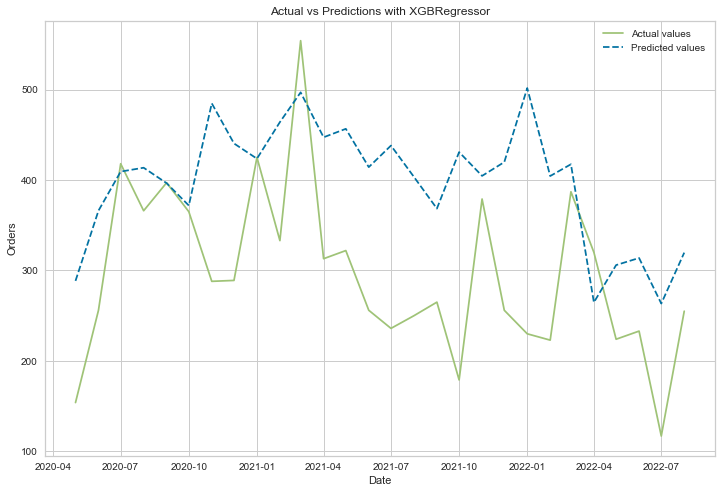

In [55]:
import xgboost as xgb

# Check xgboost version
print("XGboost version:", xgb.__version__)

# Import XGBRegressor
from xgboost import XGBRegressor         
          
# Instantiate the regressor
xgb_reg = XGBRegressor(random_state=42)

# Fit the regressor to the training data
xgb_reg.fit(X_train, y_train)

# Compute and print model score
scoring(xgb_reg, X_test, y_test)

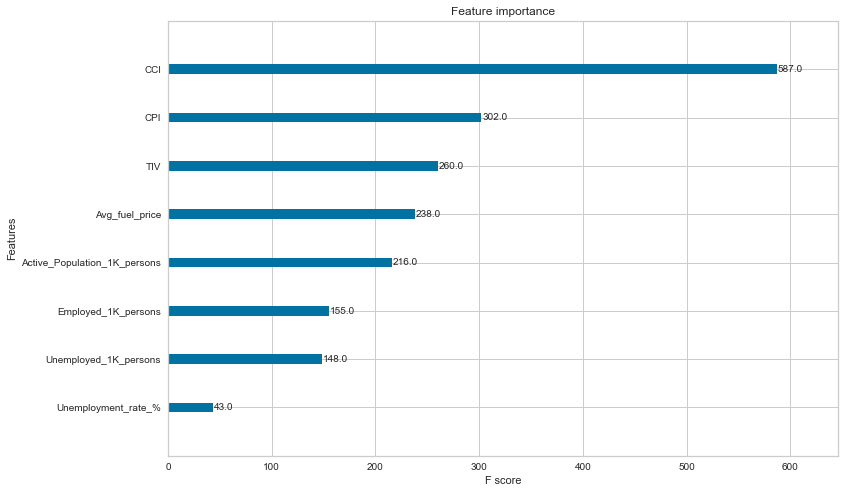

In [56]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(xgb_reg, ax=ax)
plt.show();

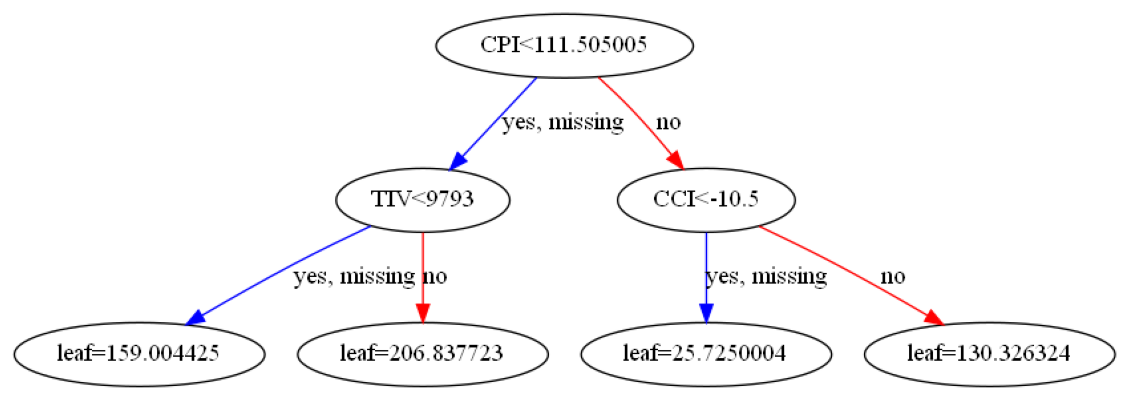

In [57]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(xgb_reg, ax=ax)
plt.show()

In [58]:
xgb_reg

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

#### Hyperparameters Tuning

In [59]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
xgb_n_estimators = [100, 500, 1000]
xgb_max_depth = [4, 6, 8, 10]
xgb_min_child_weight = [1, 3, 5 , 7]
xgb_eta = [0.001, 0.01, 0.1, 0.2, 0.3]
xgb_subsample = [0.9, 0.5, 0.2, 0.1]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
param_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'eta': xgb_eta,
            'subsample': xgb_subsample,
            'objective': xgb_objective}

# Tune the Model
xgb_base = XGBRegressor(random_state=42)

xgb_grid = GridSearchCV(estimator = xgb_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

xgb_grid.fit(X_train, y_train)

xgb_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",xgb_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",xgb_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",xgb_grid.best_params_)

Fitting 4 folds for each of 1920 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 3120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4420 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5920 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7620 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:  2.7min finished


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=7,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', ...)

 The best score across ALL searched params:
 0.14201074793951873

 The best parameters across ALL searched params:
 {'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'reg:sq

#### Tuned Model

XGBRegressor Model Performance:
Mean Absolute Error: 157.1153.
Mean Squared Error: 31778.8833.
Root Mean Squared Error: 178.2663.
R^2 Score = -2.8021.
Mean Squared Log Error: 0.3079.
Root Mean Squared Log Error: 0.5549.
Mean Absolute Percentage Error: 67.6921.
Accuracy = 32.31%.


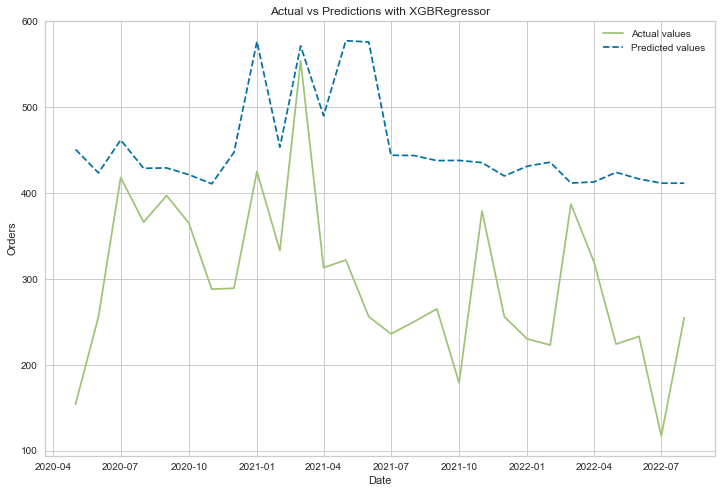

In [60]:
# Create the fnal Extreme Gradient Booster
xgb_tuned = XGBRegressor(objective = 'reg:squarederror',
                         n_estimators = 500,
                         min_child_weight = 7,
                         max_depth = 4,                         
                         subsample = 0.2,
                         eta = 0.01,
                         random_state = 42)

# Fit the regressor to the training data
xgb_tuned.fit(X_train, y_train)

# Compute and print model score
scoring(xgb_tuned, X_test, y_test)

### LightGBM Regression

#### Baseline

LigthGBM version: 3.3.4
LGBMRegressor Model Performance:
Mean Absolute Error: 128.5141.
Mean Squared Error: 22210.2276.
Root Mean Squared Error: 149.0310.
R^2 Score = -1.6572.
Mean Squared Log Error: 0.2326.
Root Mean Squared Log Error: 0.4823.
Mean Absolute Percentage Error: 54.8565.
Accuracy = 45.14%.


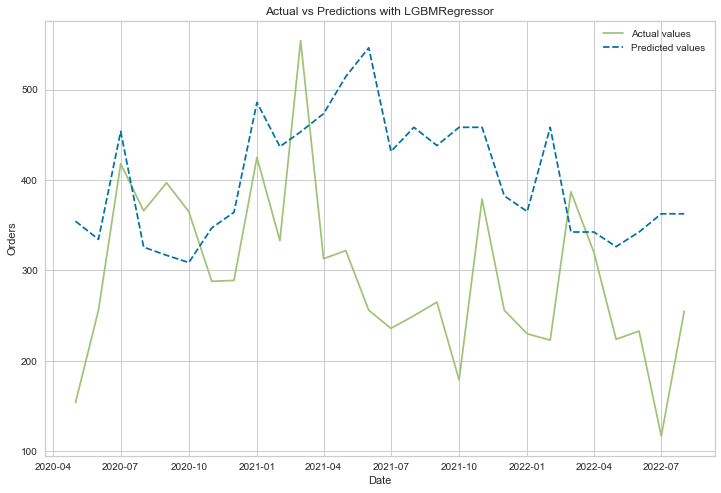

In [61]:
import lightgbm as lgbm

# Check ligthGBM version
print("LigthGBM version:", lgbm.__version__)

# Import LightGBM Regressor
from lightgbm import LGBMRegressor
          
# Instantiate the regressor
lgbm_reg = LGBMRegressor(random_state=42)

# Fit the regressor to the training data
lgbm_reg.fit(X_train, y_train)

# Compute and print model score
scoring(lgbm_reg, X_test, y_test)

In [62]:
lgbm_reg

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### Hyperparameters Tuning

In [63]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
lgbm_n_estimators = [100, 500, 1000]
lgbm_max_depth = [4, 6, 8, 10]
lgbm_num_leaves = [1, 3, 5 , 7]
lgbm_learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
lgbm_subsample = [0.9, 0.5, 0.2, 0.1]

# Create the grid
param_grid = {'n_estimators': lgbm_n_estimators,
            'max_depth': lgbm_max_depth,
            'num_leaves': lgbm_num_leaves,
            'learning_rate': lgbm_learning_rate,
            'subsample': lgbm_learning_rate
           }

# Tune the Model
lgbm_base = LGBMRegressor(random_state=42)

lgbm_grid = GridSearchCV(estimator = lgbm_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

lgbm_grid.fit(X_train, y_train)

lgbm_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",lgbm_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",lgbm_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",lgbm_grid.best_params_)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1188 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 3712 tasks      | elapsed:   28.3s


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=5, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=0.0001, subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 0.07812989107779716

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5, 'subsample': 0.0001}


[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed:   48.4s finished


#### Tuned Model

LGBMRegressor Model Performance:
Mean Absolute Error: 137.9974.
Mean Squared Error: 26259.6819.
Root Mean Squared Error: 162.0484.
R^2 Score = -2.1417.
Mean Squared Log Error: 0.2686.
Root Mean Squared Log Error: 0.5183.
Mean Absolute Percentage Error: 60.3085.
Accuracy = 39.69%.


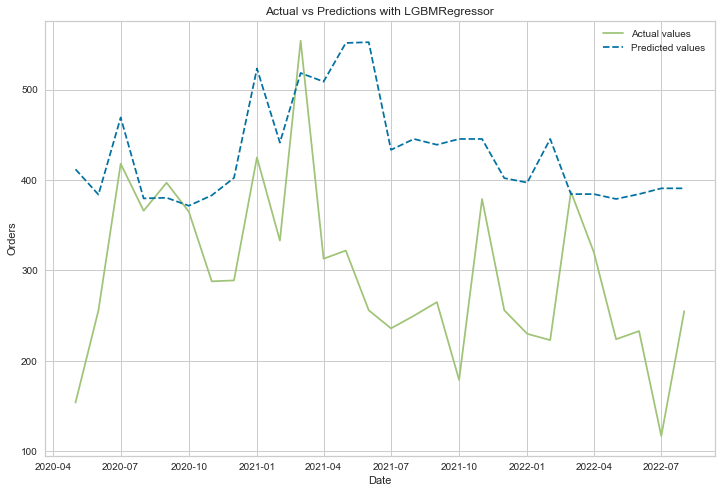

In [64]:
# Create the fnal LightGBM Model
lgbm_tuned = LGBMRegressor(n_estimators = 500,
                         num_leaves= 5,
                         max_depth = 4,                         
                         subsample = 0.0001,
                         learning_rate= 0.01,
                         random_state = 42)

# Fit the regressor to the training data
lgbm_tuned.fit(X_train, y_train)

# Compute and print model score
scoring(lgbm_tuned, X_test, y_test)

### Random Forest Regression

#### Baseline

RandomForestRegressor Model Performance:
Mean Absolute Error: 145.1639.
Mean Squared Error: 26377.5928.
Root Mean Squared Error: 162.4118.
R^2 Score = -2.1558.
Mean Squared Log Error: 0.2627.
Root Mean Squared Log Error: 0.5125.
Mean Absolute Percentage Error: 61.0253.
Accuracy = 38.97%.


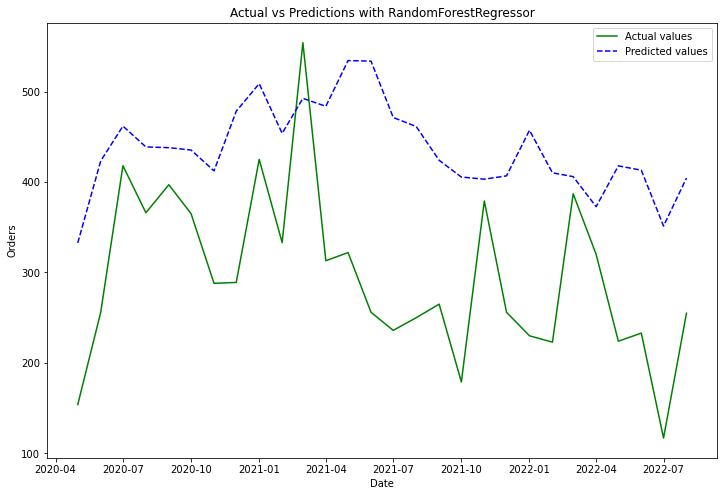

In [18]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
          
# Instantiate the regressor
rf_reg = RandomForestRegressor(random_state=42)

# Fit the regressor to the training data
rf_reg.fit(X_train, y_train)

# Compute and print model score
scoring(rf_reg, X_test, y_test)

In [19]:
rf_reg

RandomForestRegressor(random_state=42)

#### Hyperparameters Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning 
rf_n_estimators = [100, 500, 1000]
rf_max_depth = [4, 6, 8, 10]
rf_max_features = ['auto', 'sqrt']
rf_min_samples_leaf = [1, 2, 4]
rf_min_samples_split = [2, 5, 10]
rf_bootstrap = [True, False]

# Create the grid
param_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'max_features': rf_max_features,
           'min_samples_leaf': rf_min_samples_leaf,
           'min_samples_split': rf_min_samples_split,
           'bootstrap': rf_bootstrap
        }

# Tune the Model
rf_base = RandomForestRegressor(random_state=42)

rf_grid = GridSearchCV(estimator = rf_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

rf_grid.fit(X_train, y_train)

rf_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",rf_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",rf_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",rf_grid.best_params_)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.2min


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=8, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)

 The best score across ALL searched params:
 0.028845345356432683

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  4.2min finished


#### Tuned Model

RandomForestRegressor Model Performance:
Mean Absolute Error: 150.5736.
Mean Squared Error: 28557.8136.
Root Mean Squared Error: 168.9906.
R^2 Score = -2.4167.
Mean Squared Log Error: 0.2876.
Root Mean Squared Log Error: 0.5363.
Mean Absolute Percentage Error: 64.6067.
Accuracy = 35.39%.


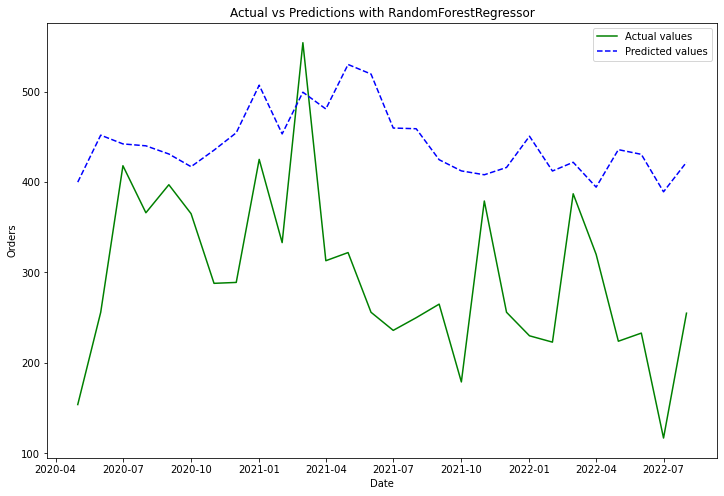

In [21]:
# Create the fnal Random Forest Regressor Model
rf_tuned = RandomForestRegressor(n_estimators = 100,
                         max_depth = 8,                         
                         max_features = 'auto',
                         min_samples_leaf= 2,
                         min_samples_split = 10,
                         bootstrap = True,
                         random_state = 42)

# Fit the regressor to the training data
rf_tuned.fit(X_train, y_train)

# Compute and print model score
scoring(rf_tuned, X_test, y_test)

## Summary

# Other tests

### XGBoost (Extreme Gradient Boosting)

In [12]:
import xgboost as xgb
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)

scoring(xgb, X_test, y_test)

Model Performance
Mean Absolute Error: 110.2013.
Mean Squared Error: 17548.6442.
R^2 Score = -1.0995.
Accuracy = 53.27%.


In [13]:
xgb.feature_importances_

array([0.06292622, 0.19028747, 0.        , 0.08134924, 0.32268733,
       0.18839407, 0.07928713, 0.05888204, 0.0161865 ], dtype=float32)

In [14]:
xgb.plot_importance(xgb_regressor, ax=plt.gca())

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

### Cross-validation

In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

# Create the models to be tested
mlgbm = lgbm.LGBMRegressor()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

models = [mlgbm, rf_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

LGBMRegressor()  RandomForestRegressor(random_state=42)  \
Mean Absolute Error          60.6684                                 12.0140   
Mean Squared Error         8132.2444                                821.6734   
R^2                           0.7880                                  0.9801   
Accuracy                     89.2095                                 97.8632   

                     XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=100, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=42, ...)  
Mean Absolute Error                                            12.9273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Mean Squared Error                                            451.0516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
R^2                                                             0.9885                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Accuracy                                                       97.7008

In [16]:
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', 
                                                         '4th Fold'])

r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)

r2_comp

1st Fold  2nd Fold  \
LGBMRegressor()                                       0.8006    0.7286   
RandomForestRegressor(random_state=42)                0.9872    0.9921   
XGBRegressor(base_score=None, booster=None, cal...    0.9935    0.9896   

                                                    3rd Fold  4th Fold  \
LGBMRegressor()                                       0.8202    0.8027   
RandomForestRegressor(random_state=42)                0.9889    0.9521   
XGBRegressor(base_score=None, booster=None, cal...    0.9944    0.9765   

                                                    Average  
LGBMRegressor()                                      0.7880  
RandomForestRegressor(random_state=42)               0.9801  
XGBRegressor(base_score=None, booster=None, cal...   0.9885

### Hyperparameters Tuning - Random Forest

In [17]:
# Set hyperparameters possibilities for tuning Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'absolute_error']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'absolute_error'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [18]:
from sklearn.model_selection import RandomizedSearchCV
# Tune the Random Forest Model
rf_base = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

rf_random.fit(X_train_temp, y_train_temp)

rf_random.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=35,
                      min_impurity_decrease=0.1, min_samples_split=4,
                      n_estimators=600)

### Hyperparameters Tuning - XGBoost (Extreme Gradient Boosting)

In [19]:
# Set hyperparameters possibilities for tuning XGBoost
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist'
]
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

# Tune the XGBoost Model
xgb_base = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

xgb_random.fit(X_train_temp, y_train_temp)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


{'tree_method': 'auto',
 'objective': 'reg:squarederror',
 'n_estimators': 200,
 'min_child_weight': 2,
 'max_depth': 6,
 'gamma': 0,
 'eta': 0.30000000000000004}

### Final Evaluation

In [20]:
# Create the final LigthGBM

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 600,
                                 min_samples_split = 4,
                                 min_impurity_decrease = 0.1,
                                 max_features = 'sqrt',
                                 max_depth = 35,
                                 criterion = 'absolute_error',
                                 bootstrap = False,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'auto',
                         objective = 'reg:squarederror',
                         n_estimators = 200,
                         min_child_weight = 2,
                         max_depth = 6,
                         gamma = 0,
                         eta = 0.3,
                         random_state = 42)

# Train the models using 80% of the original data
# LGBM goes here --
rf_final.fit(X_train_temp, y_train_temp)
xgb_final.fit(X_train_temp, y_train_temp)

# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores
    
# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

LGBMRegressor()  RandomForestRegressor(random_state=42)  \
Mean Absolute Error          60.6684                                 12.0140   
Mean Squared Error         8132.2444                                821.6734   
R^2                           0.7880                                  0.9801   
Accuracy                     89.2095                                 97.8632   

                     XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=100, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=42, ...)  
Mean Absolute Error                                            12.9273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Mean Squared Error                                            451.0516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
R^2                                                             0.9885                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Accuracy                                                       97.7008

### XGBoost (Extreme Gradient Boosting)

In [20]:
import xgboost as xgb

# check xgboost version
print(xgb.__version__)

# Select input and target variables
X = data.drop(['Orders'], axis=1)
y = data["Orders"]

# Create the DMatrix 
dmatrix = xgb.DMatrix(data=X, label=y)

# Definiing params
params={"objective":"reg:squarederror","max_depth":4}

# L1 regularization
reg_params = [1,10,100]
rmses_l1=[]

for reg in reg_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=dmatrix, params=params,nfold=4,num_boost_round=10,metrics="rmse",as_pandas=True,seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(reg_params,rmses_l1)), columns=["l1","rmse"]))

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# L2 regularization
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

1.7.2
Best rmse as a function of l1:
    l1        rmse
0    1  141.909760
1   10  142.030444
2  100  149.481071
Best rmse as a function of l2:
    l2        rmse
0    1  184.852129
1   10  210.660478
2  100  351.448666


In [118]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9,rankdir="LR")
plt.show()

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'train'

### Model tuning

In [26]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

dmatrix = xgb.DMatrix(data=X,label=y)

gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
                    'n_estimators': [200],
                    'subsample': np.arange(0.05,1.05,.05)}

gbm = xgb.XGBRegressor()

randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=25, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.3, 'n_estimators': 200, 'learning_rate': 0.05}
Lowest RMSE found:  181.18036412771912


In [28]:
# Create the DMatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

   num_boosting_rounds        rmse
0                    5  183.122624
1                   10  147.596829
2                   15  145.746563


In [21]:
X_train.shape, X_test.shape

((112, 13), (28, 13))

In [29]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [25]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 72.653859


In [32]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [33]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       368.897880       12.618361      368.081924      28.865079
1       337.347801       11.430440      337.864388      30.209572
2       308.618192       10.960824      309.358712      31.367627
3       282.799589       10.193485      283.653487      32.242495
4       259.745429        9.594686      261.709599      32.982860

In [34]:
print((cv_results["test-rmse-mean"]).tail(1))

32    115.488021
Name: test-rmse-mean, dtype: float64


In [35]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [22]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_tree'

In [119]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

## Choosing classifier

In [120]:
from xgboost import XGBRegressor
import xgboost as xgb
#create an xgboost regression model
model = XGBRegressor()

## Fitting the model

In [121]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

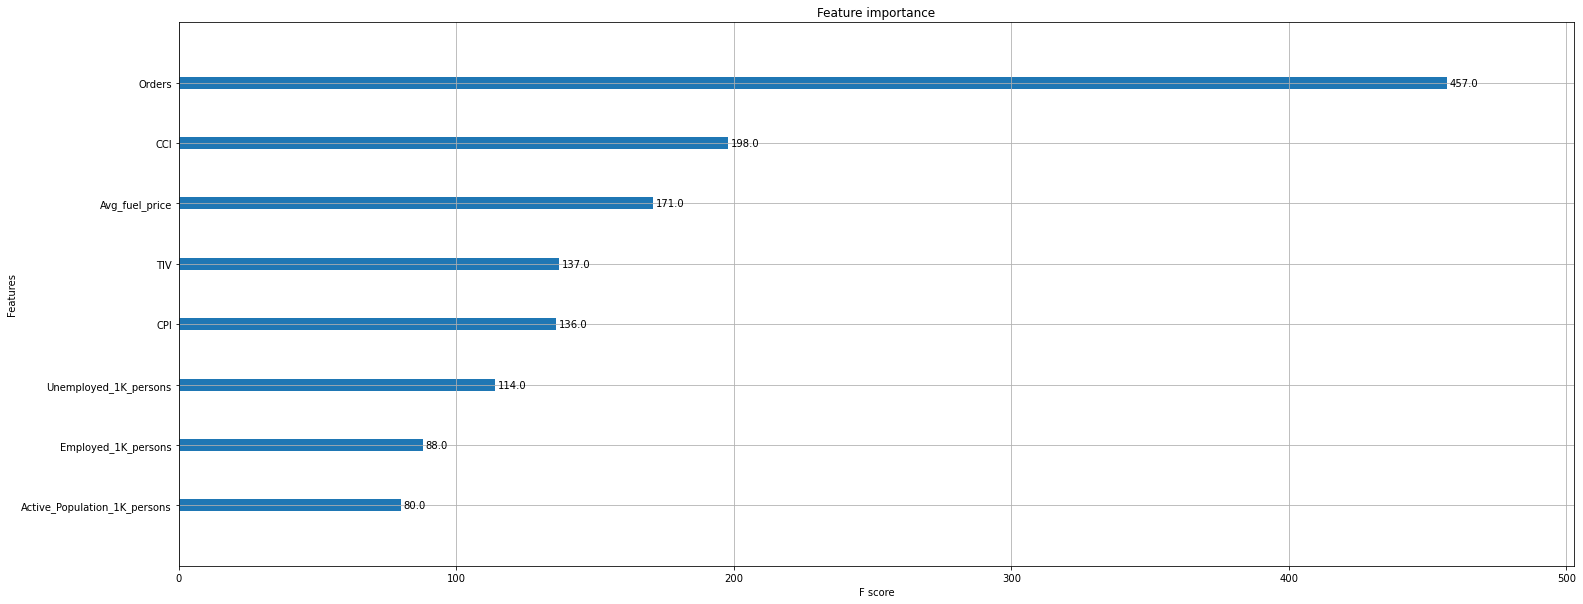

In [122]:
xgb.plot_importance(model, ax=plt.gca())

## Tuning hyperparameters

In [ ]:
# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [26]:
# evaluate an xgboost regression model 
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# split data into input and output columns
X, y = datavalues[:, :-1], datavalues[:, -1]
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 20.692 (7.774)


In [51]:
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [52]:
import xgboost
reg = xgboost.XGBRegressor(objective='reg:squarederror', \
                           n_estimators=1000, \
                          nthread=24)
reg.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=24,
             nthread=24, num_parallel_tree=1, predictor='auto', ...)

In [53]:
predictions_xgb = reg.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)

XGBoost - Root Mean Square Error (RMSE): 68.086
